In [1]:
#https://www.kaggle.com/code/pythonafroz/solar-power-generation-forecast-with-99-auc

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('precision',3)

In [4]:
#import both the generation and weather data for plant 2
gen_data2 = pd.read_csv('Plant_2_Generation_Data.csv')
wea_data2 = pd.read_csv('Plant_2_Weather_Sensor_Data.csv')

In [5]:
#View the gen data but with pretty colors
gen_data2.sample(5).style.set_properties(
    **{
        'background-color': 'OliveDrab',
        'color': 'white',
        'border-color': 'darkblack'
    })

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
810,2020-05-15 09:00:00,4136001,rrq4fwE8jgrTyWY,840.500,822.527,1240.000,120965348.000
42452,2020-06-06 01:00:00,4136001,Qf4GUc1pJu5T6c6,0.000,0.000,7599.000,838582222.000
42061,2020-06-05 20:30:00,4136001,oZ35aAeoifZaQzV,0.000,0.000,7708.000,1660126361.000
54533,2020-06-11 18:15:00,4136001,WcxssY2VbP4hApt,35.167,33.993,3940.667,181876742.667
53652,2020-06-11 08:15:00,4136001,V94E5Ben1TlhnDV,177.227,173.633,187.000,1412265029.000


In [6]:
#wea data but with pretty colors
wea_data2.sample(5).style.set_properties(
    **{
        'background-color': 'pink',
        'color': 'Black',
        'border-color': 'darkblack'
    })

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
2567,2020-06-10 19:00:00,4136001,iq8k7ZNt4Mwm3w0,25.680,23.941,0.000
45,2020-05-15 11:15:00,4136001,iq8k7ZNt4Mwm3w0,34.252,54.894,0.970
500,2020-05-20 05:30:00,4136001,iq8k7ZNt4Mwm3w0,23.869,22.127,0.000
1007,2020-05-25 12:15:00,4136001,iq8k7ZNt4Mwm3w0,34.031,55.332,0.908
2915,2020-06-14 10:00:00,4136001,iq8k7ZNt4Mwm3w0,28.864,38.064,0.469


In [7]:
#CLEANING
#Adjust the datetime format (just on 2 because 1
gen_data2['DATE_TIME'] = pd.to_datetime(gen_data2['DATE_TIME'],format = '%Y-%m-%d %H:%M')
wea_data2['DATE_TIME'] = pd.to_datetime(wea_data2['DATE_TIME'],format = '%Y-%m-%d %H:%M:%S')

In [8]:
#wea data but with pretty colors
wea_data2.sample(5).style.set_properties(
    **{
        'background-color': 'pink',
        'color': 'Black',
        'border-color': 'darkblack'
    })

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
2085,2020-06-05 18:30:00,4136001,iq8k7ZNt4Mwm3w0,28.047,27.305,0.014
58,2020-05-15 14:30:00,4136001,iq8k7ZNt4Mwm3w0,37.268,51.359,0.681
195,2020-05-17 01:00:00,4136001,iq8k7ZNt4Mwm3w0,25.763,24.348,0.000
1040,2020-05-25 20:30:00,4136001,iq8k7ZNt4Mwm3w0,33.424,30.886,0.000
1343,2020-05-29 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.803,25.374,0.000


In [9]:
#CLEANING
#Merge the two csv files so it's useable
df_solar = pd.merge(gen_data2.drop(columns = ['PLANT_ID']), wea_data2.drop(columns = ['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME')
df_solar.sample(5).style.background_gradient(cmap='cool')

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
12154,2020-05-21 02:45:00,4UPUqMRk7TRMgml,0.000,0.000,0.000,2464264.000,23.876,22.375,0.000
62521,2020-06-15 13:00:00,oZ35aAeoifZaQzV,0.000,0.000,1077.000,1660177169.000,31.107,41.349,0.425
61405,2020-06-15 00:15:00,xoJJ8DcxJEcupym,0.000,0.000,7268.000,209319687.000,24.509,23.903,0.000
60311,2020-06-14 12:00:00,LYwnQax7tkwH5Cb,782.173,765.200,3302.400,1795097092.400,30.992,42.587,0.586
25727,2020-05-28 23:15:00,81aHJ1q11NBPMrL,0.000,0.000,8947.000,1215372608.000,27.441,26.110,0.000


In [10]:
#CLEANING
#Add separate time and date columns
# adding separate time and date columns
df_solar["DATE"] = pd.to_datetime(df_solar["DATE_TIME"]).dt.date
df_solar["TIME"] = pd.to_datetime(df_solar["DATE_TIME"]).dt.time
df_solar['DAY'] = pd.to_datetime(df_solar['DATE_TIME']).dt.day
df_solar['MONTH'] = pd.to_datetime(df_solar['DATE_TIME']).dt.month
df_solar['WEEK'] = pd.to_datetime(df_solar['DATE_TIME']).dt.week


# add hours and minutes for ml models
df_solar['HOURS'] = pd.to_datetime(df_solar['TIME'],format='%H:%M:%S').dt.hour
df_solar['MINUTES'] = pd.to_datetime(df_solar['TIME'],format='%H:%M:%S').dt.minute
df_solar['TOTAL MINUTES PASS'] = df_solar['MINUTES'] + df_solar['HOURS']*60

# add date as string column
df_solar["DATE_STRING"] = df_solar["DATE"].astype(str) # add column with date as string
df_solar["HOURS"] = df_solar["HOURS"].astype(str)
df_solar["TIME"] = df_solar["TIME"].astype(str)

df_solar.head(2)

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE,TIME,DAY,MONTH,WEEK,HOURS,MINUTES,TOTAL MINUTES PASS,DATE_STRING
0,2020-05-15,4UPUqMRk7TRMgml,0.0,0.0,9425.0,2.429e+06,27.005,25.061,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15
1,2020-05-15,81aHJ1q11NBPMrL,0.0,0.0,0.0,1.215e+09,27.005,25.061,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15


In [11]:
df_solar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67698 entries, 0 to 67697
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            67698 non-null  datetime64[ns]
 1   SOURCE_KEY           67698 non-null  object        
 2   DC_POWER             67698 non-null  float64       
 3   AC_POWER             67698 non-null  float64       
 4   DAILY_YIELD          67698 non-null  float64       
 5   TOTAL_YIELD          67698 non-null  float64       
 6   AMBIENT_TEMPERATURE  67698 non-null  float64       
 7   MODULE_TEMPERATURE   67698 non-null  float64       
 8   IRRADIATION          67698 non-null  float64       
 9   DATE                 67698 non-null  object        
 10  TIME                 67698 non-null  object        
 11  DAY                  67698 non-null  int64         
 12  MONTH                67698 non-null  int64         
 13  WEEK                 67698 non-

In [12]:
#check for nulls
df_solar.isnull().sum()
#No nulls! :)

DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
DATE                   0
TIME                   0
DAY                    0
MONTH                  0
WEEK                   0
HOURS                  0
MINUTES                0
TOTAL MINUTES PASS     0
DATE_STRING            0
dtype: int64

In [13]:
df_solar.describe().style.background_gradient(cmap='rainbow')

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,MONTH,WEEK,MINUTES,TOTAL MINUTES PASS
count,67698.000,67698.000,67698.000,67698.000,67698.000,67698.000,67698.000,67698.000,67698.000,67698.000,67698.000,67698.000
mean,246.702,241.278,3294.890,658944788.424,27.987,32.607,0.229,15.531,5.530,22.563,22.517,714.330
std,370.570,362.112,2919.448,729667771.073,4.021,11.226,0.309,8.528,0.499,1.475,16.764,415.672
min,0.000,0.000,0.000,0.000,20.942,20.265,0.000,1.000,5.000,20.000,0.000,0.000
25%,0.000,0.000,272.750,19964944.867,24.570,23.686,0.000,9.000,5.000,21.000,15.000,360.000
50%,0.000,0.000,2911.000,282627587.000,26.910,27.434,0.019,16.000,6.000,23.000,30.000,720.000
75%,446.592,438.215,5534.000,1348495113.000,30.913,40.019,0.431,22.000,6.000,24.000,45.000,1080.000
max,1420.933,1385.420,9873.000,2247916295.000,39.182,66.636,1.099,31.000,6.000,25.000,45.000,1425.000


In [14]:
#CLEANING
#Converting 'SOURCE_KEY' from categorical form to numerical form
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_solar['SOURCE_KEY_NUMBER'] = encoder.fit_transform(df_solar['SOURCE_KEY'])
df_solar.head()

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE,TIME,DAY,MONTH,WEEK,HOURS,MINUTES,TOTAL MINUTES PASS,DATE_STRING,SOURCE_KEY_NUMBER
0,2020-05-15,4UPUqMRk7TRMgml,0.0,0.0,9425.000,2.429e+06,27.005,25.061,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15,0
1,2020-05-15,81aHJ1q11NBPMrL,0.0,0.0,0.000,1.215e+09,27.005,25.061,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15,1
2,2020-05-15,9kRcWv60rDACzjR,0.0,0.0,3075.333,2.248e+09,27.005,25.061,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15,2
3,2020-05-15,Et9kgGMDl729KT4,0.0,0.0,269.933,1.704e+06,27.005,25.061,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15,3
4,2020-05-15,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000,1.994e+07,27.005,25.061,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15,4


In [15]:
#DATA VISUALIZATION

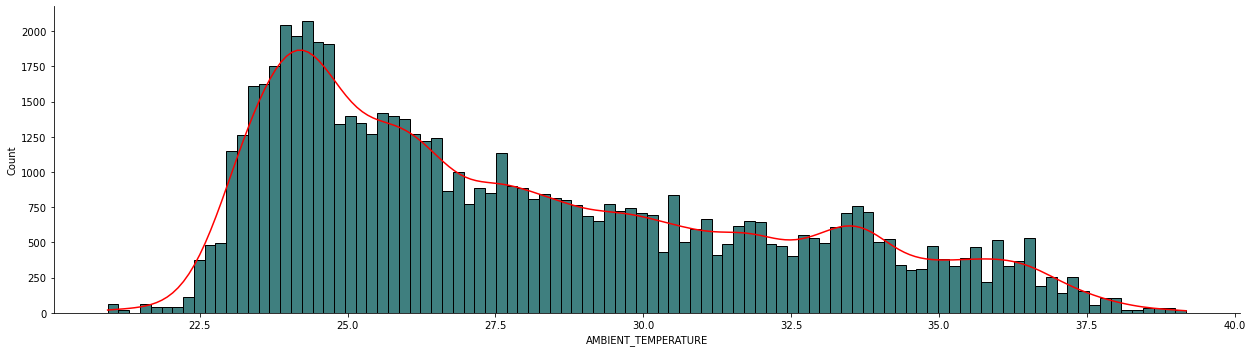

In [16]:
sns.displot(data=df_solar, x="AMBIENT_TEMPERATURE", kde=True, bins = 100,color = "red", facecolor = "#3F7F7F",height = 5, aspect = 3.5);

In [17]:
#Check the number of days that we're dealing with here
df_solar['DATE'].nunique()

34

In [18]:
#Faults & Abnormalities detection in solar power plant generation

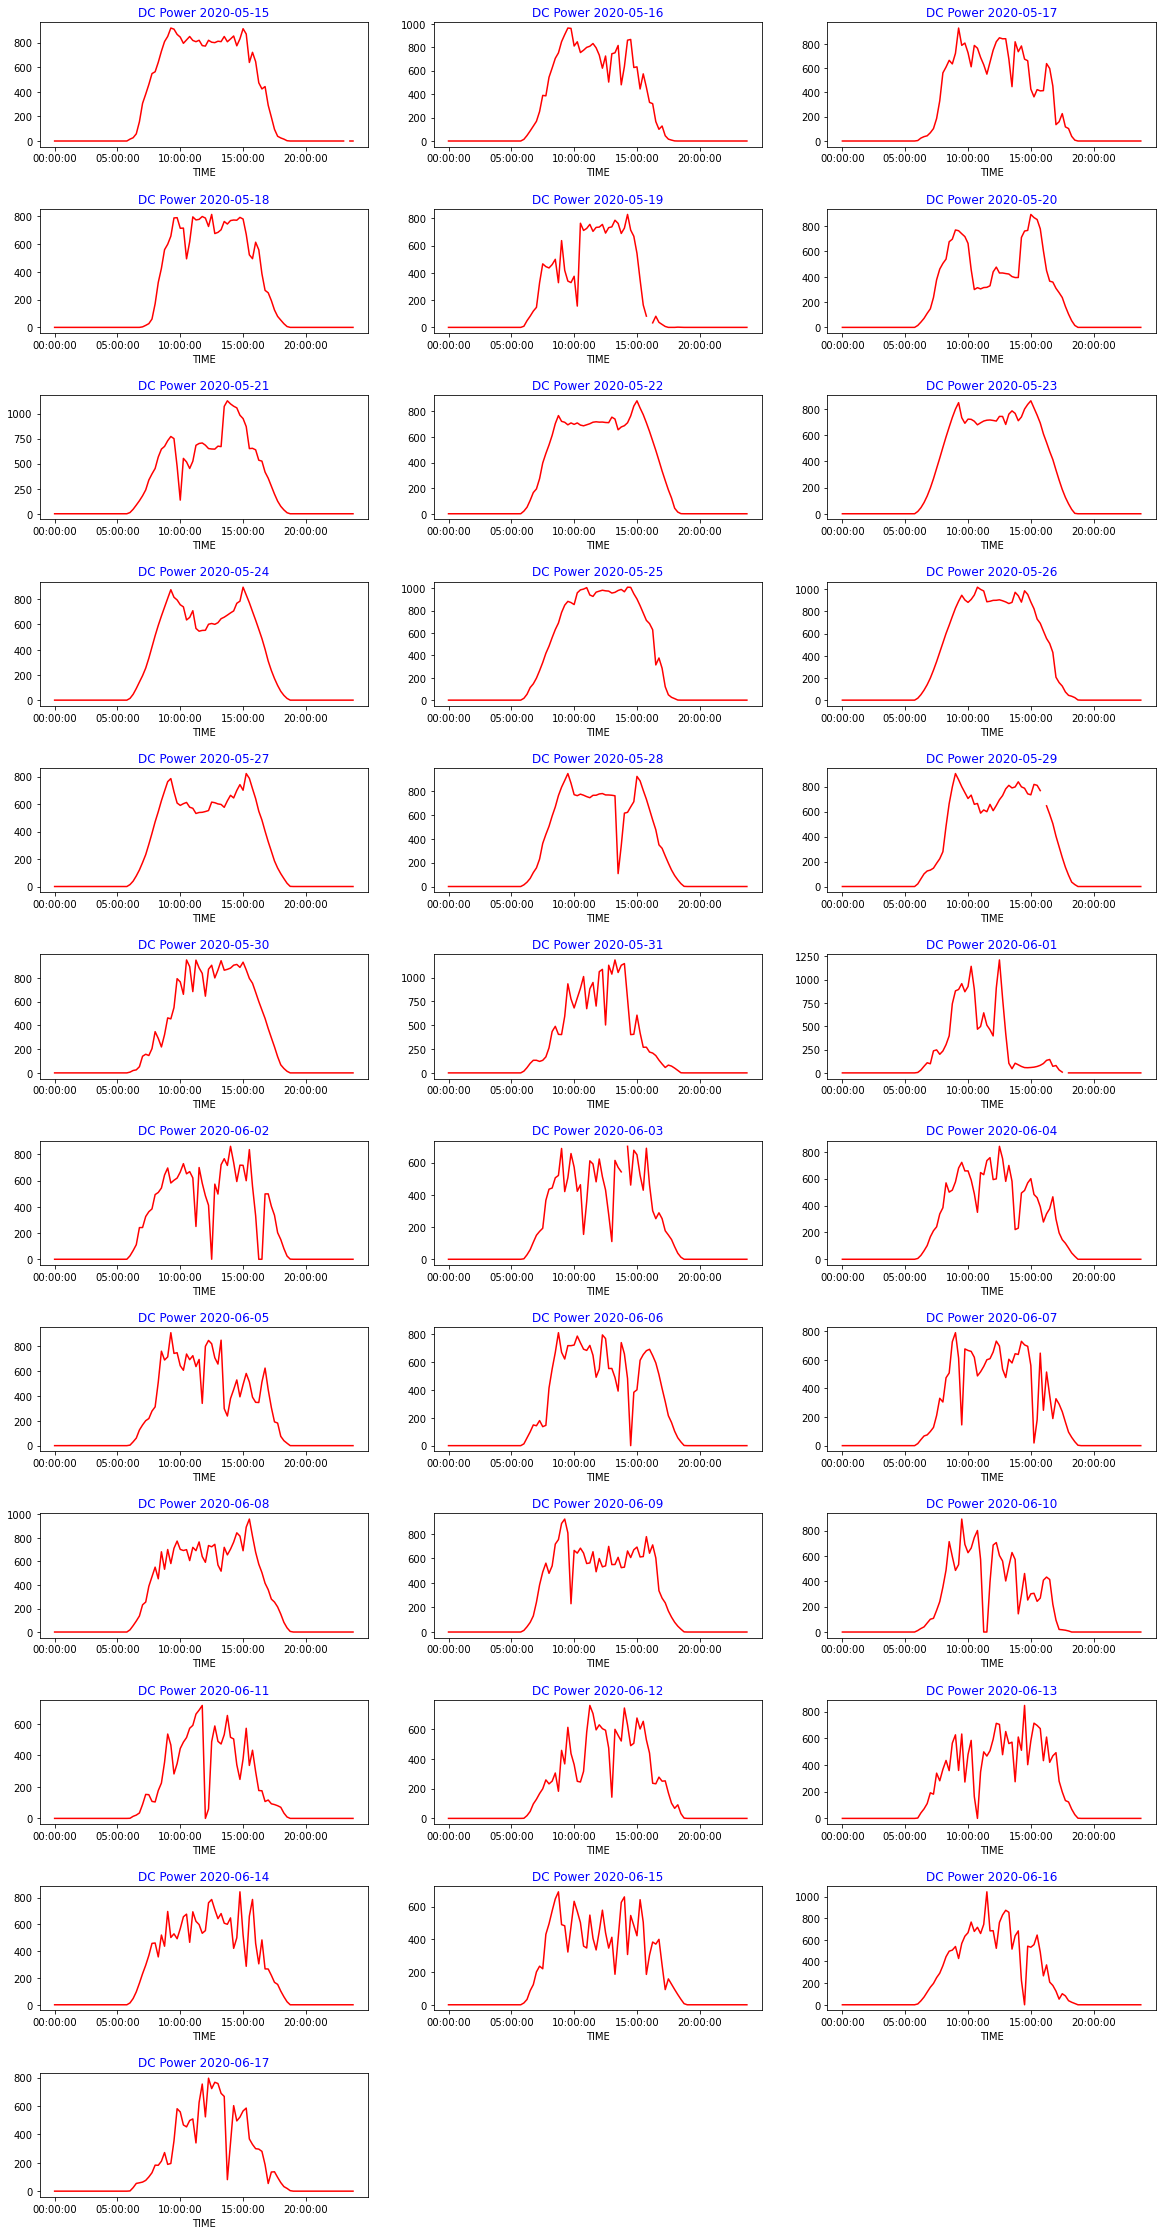

In [19]:
#Multiple Plotting of DC_POWER generation on per day basis
solar_dc = df_solar.pivot_table(values='DC_POWER', index='TIME', columns='DATE')

def Daywise_plot(data= None, row = None, col = None, title='DC Power'):
    cols = data.columns # take all column
    gp = plt.figure(figsize=(20,40)) 
    
    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols)+1):
        ax = gp.add_subplot(row,col, i)
        data[cols[i-1]].plot(ax=ax, color='red')
        ax.set_title('{} {}'.format(title, cols[i-1]),color='blue')
        
Daywise_plot(data=solar_dc, row=12, col=3)

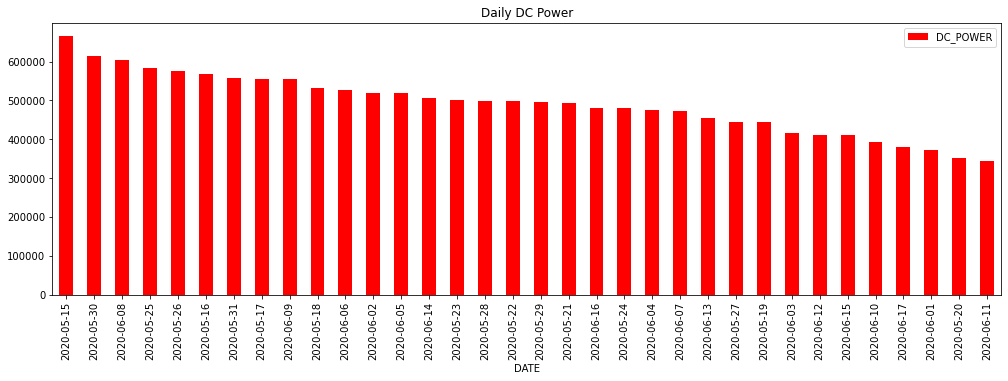

In [20]:
daily_dc = df_solar.groupby('DATE')['DC_POWER'].agg('sum')

ax = daily_dc.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='red')
plt.title('Daily DC Power')
plt.show()

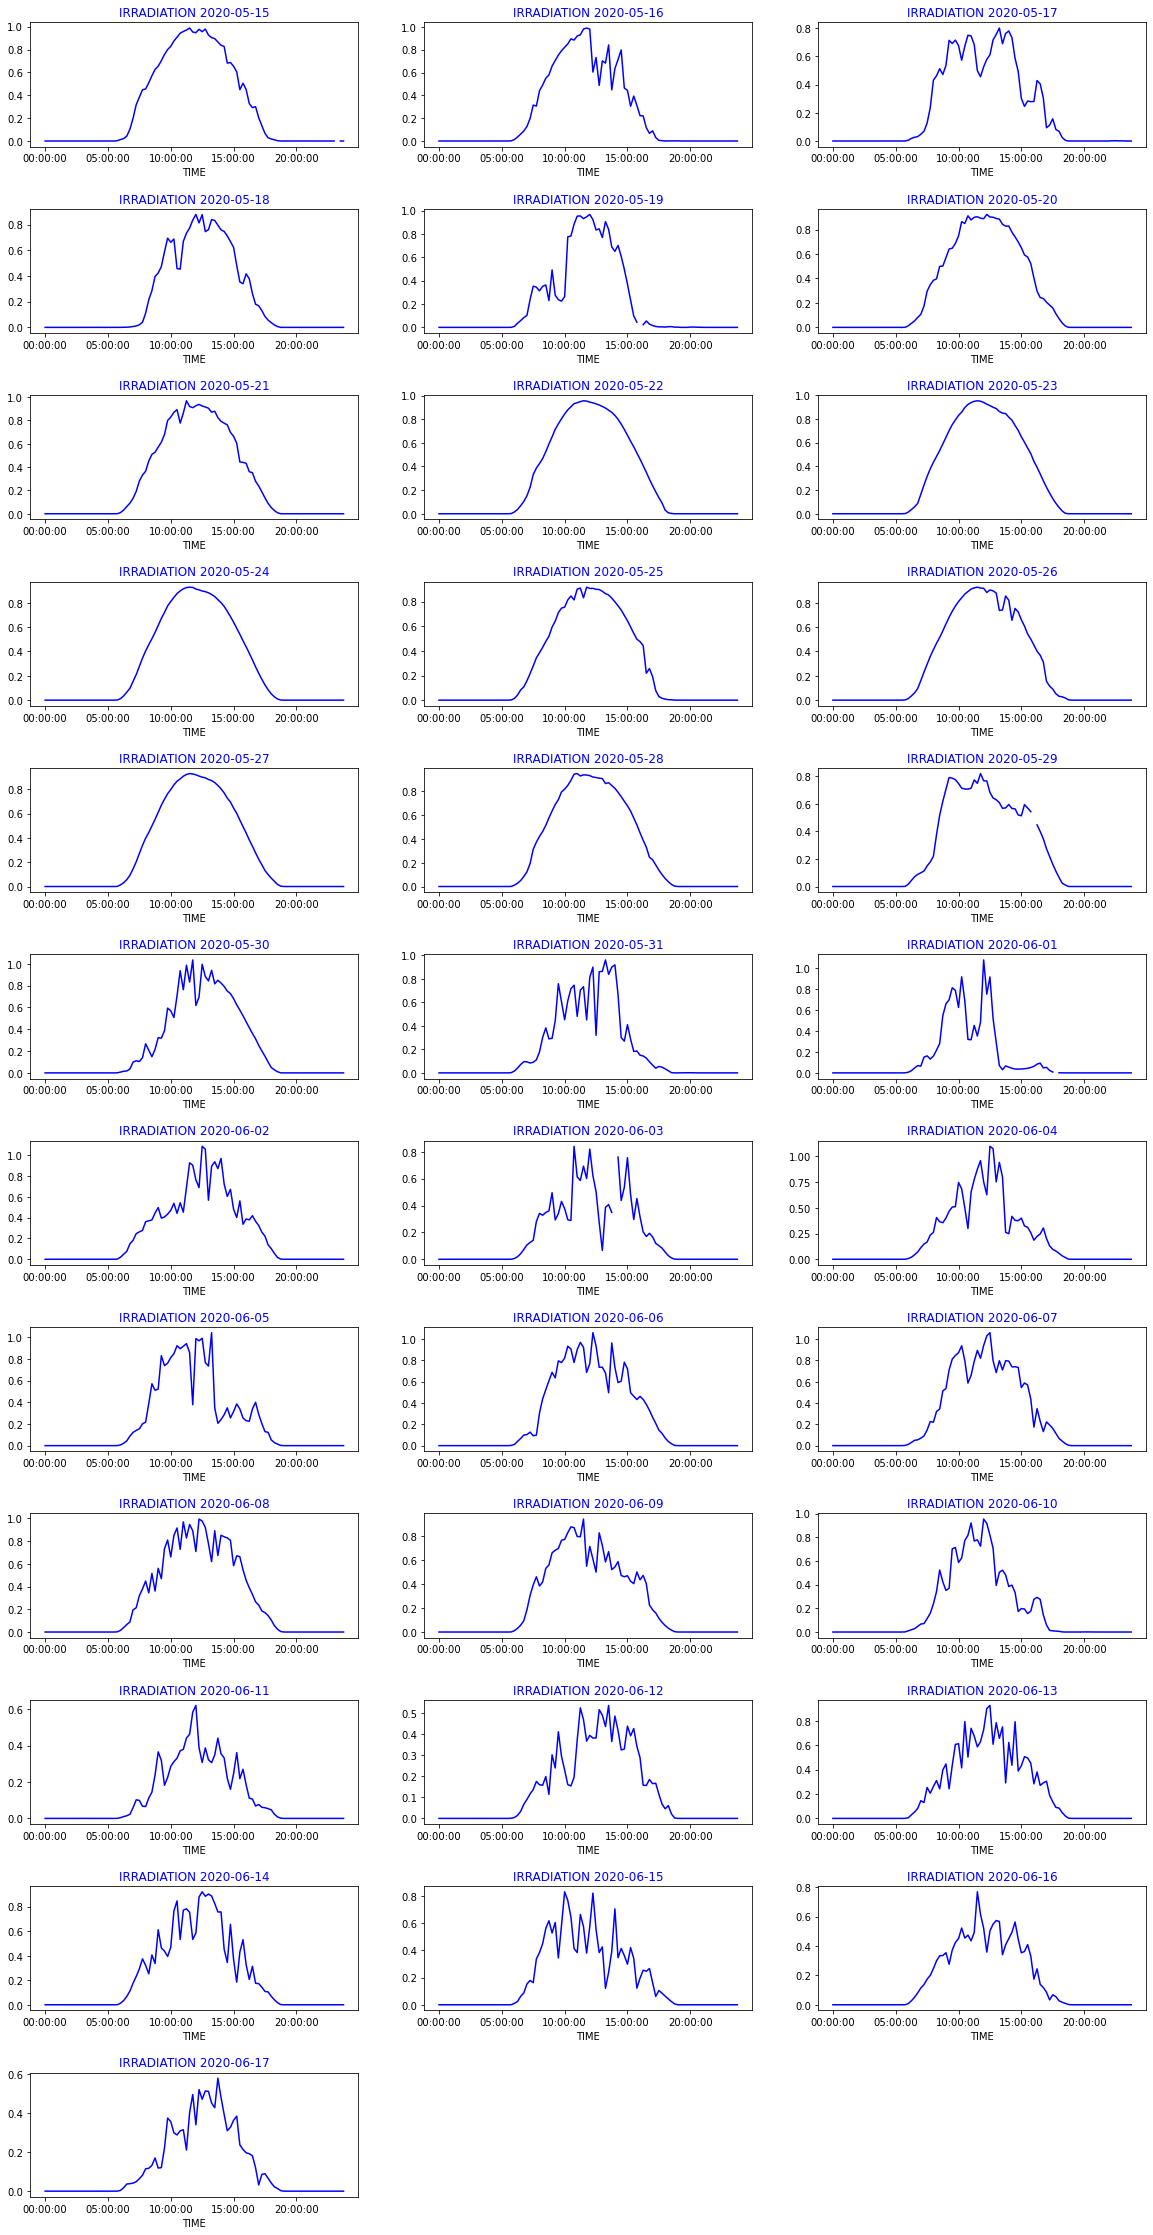

In [21]:
#Multiple Plotting of IRRADIATION generation on per day basis.
solar_irradiation = df_solar.pivot_table(values='IRRADIATION', index='TIME', columns='DATE')

def Daywise_plot(data= None, row = None, col = None, title='IRRADIATION'):
    cols = data.columns # take all column
    gp = plt.figure(figsize=(20,40)) 
    
    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols)+1):
        ax = gp.add_subplot(row,col, i)
        data[cols[i-1]].plot(ax=ax, color='blue')
        ax.set_title('{} {}'.format(title, cols[i-1]),color='blue')
        
Daywise_plot(data=solar_irradiation, row=12, col=3)

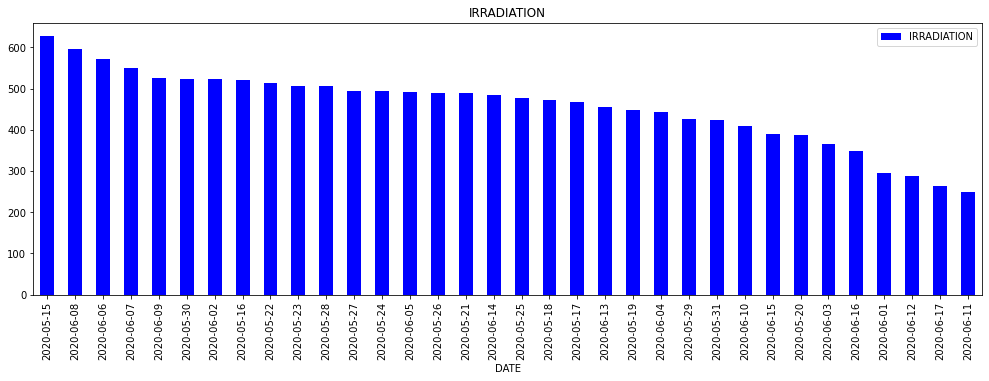

In [22]:
daily_irradiation = df_solar.groupby('DATE')['IRRADIATION'].agg('sum')

daily_irradiation.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='blue')
plt.title('IRRADIATION')
plt.show()

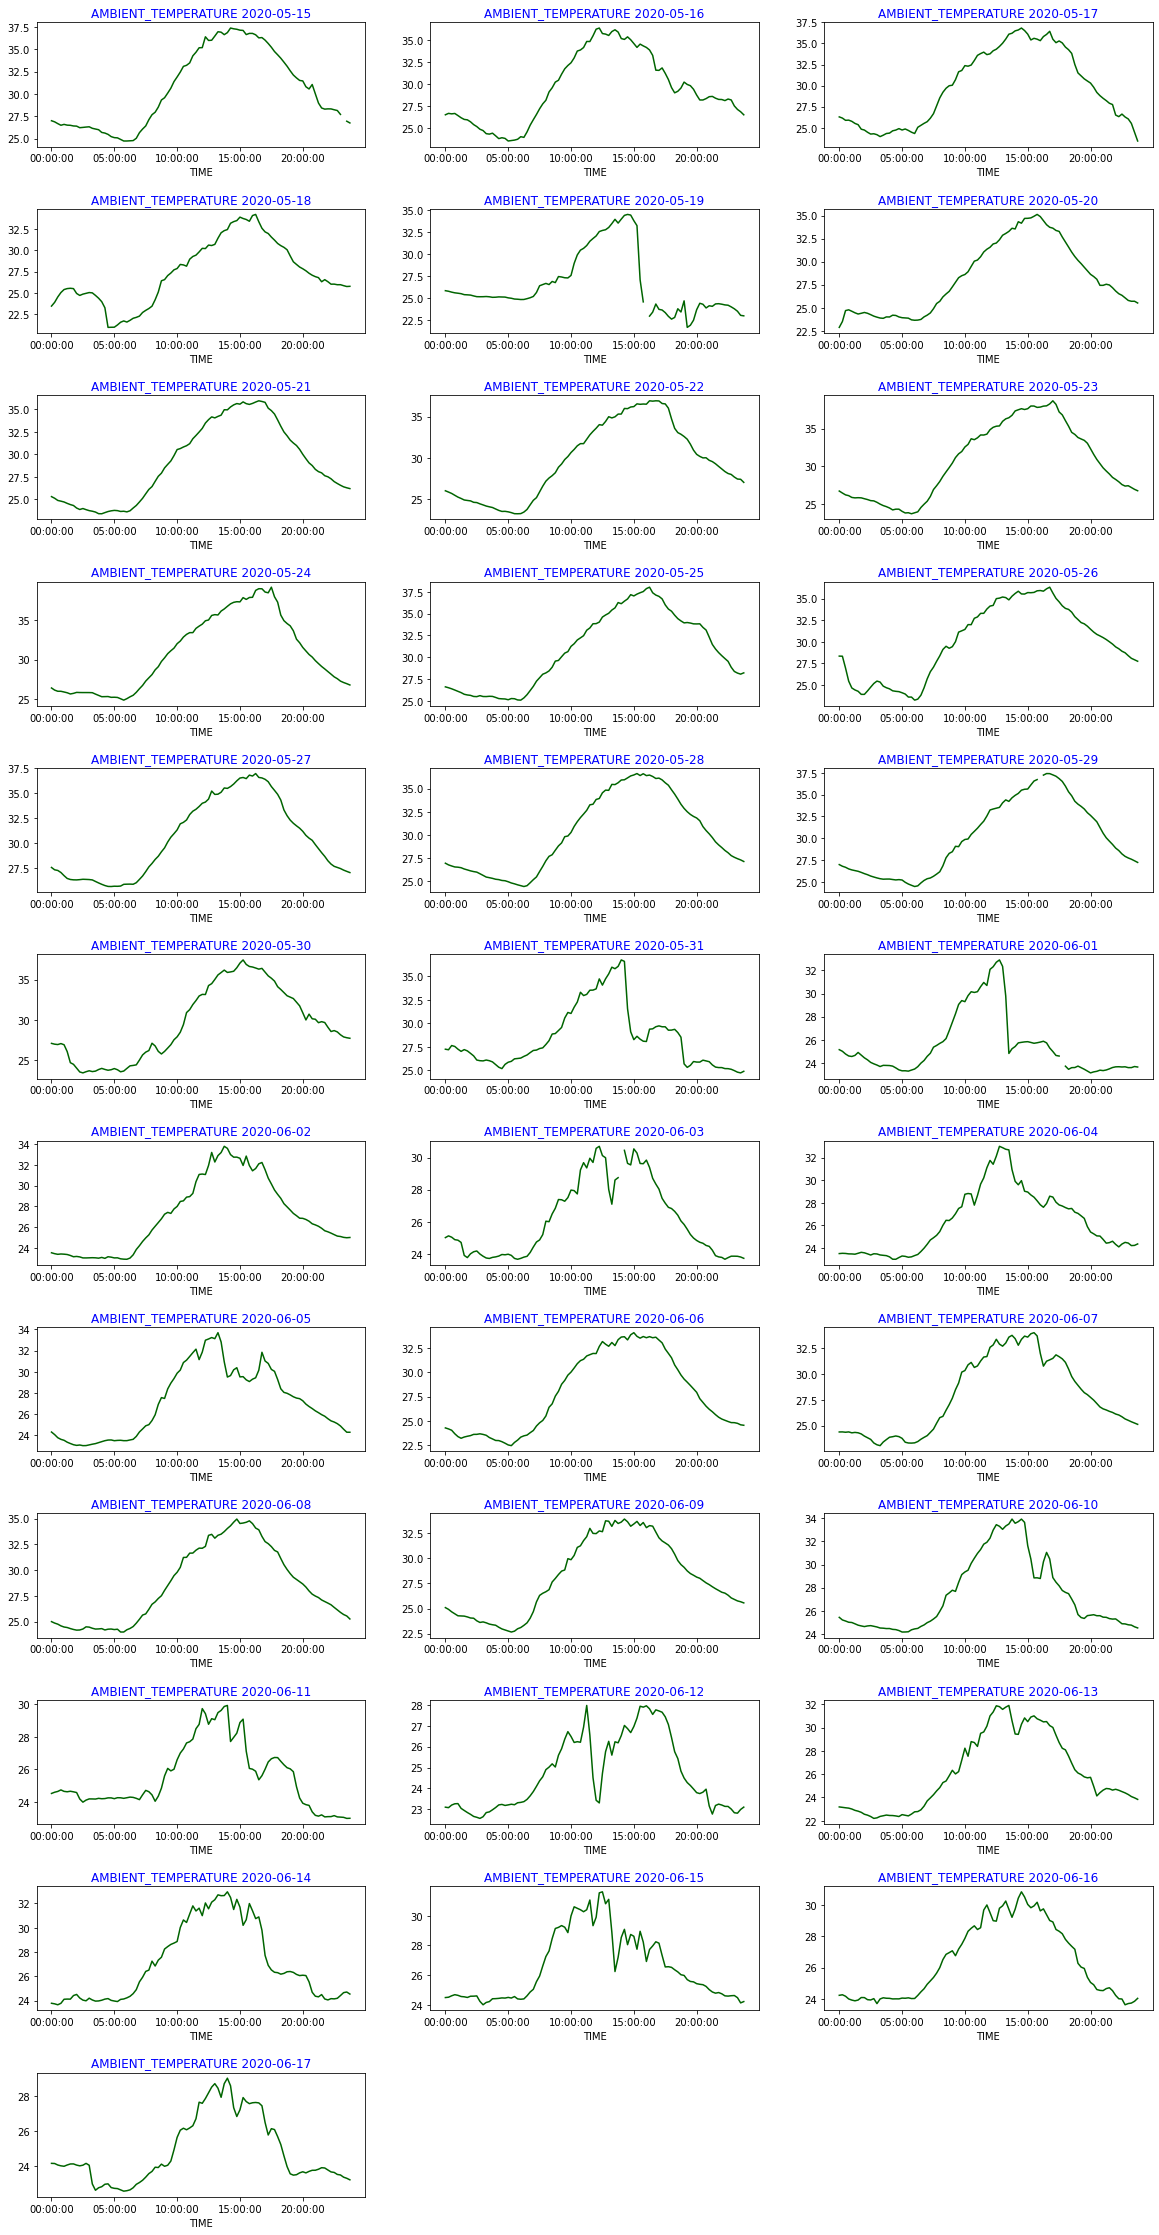

In [23]:
#Multiple Plotting of AMBIANT TEMP generation on per day basis.
solar_ambiant_temp = df_solar.pivot_table(values='AMBIENT_TEMPERATURE', index='TIME', columns='DATE')

def Daywise_plot(data= None, row = None, col = None, title='AMBIENT_TEMPERATURE'):
    cols = data.columns # take all column
    gp = plt.figure(figsize=(20,40)) 
    
    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols)+1):
        ax = gp.add_subplot(row,col, i)
        data[cols[i-1]].plot(ax=ax, color='darkgreen')
        ax.set_title('{} {}'.format(title, cols[i-1]),color='blue')
        
Daywise_plot(data=solar_ambiant_temp, row=12, col=3)

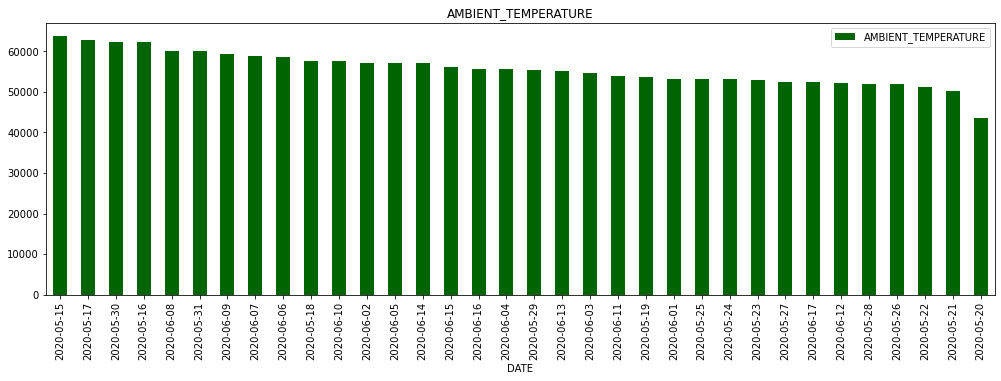

In [24]:
daily_ambient_temp = df_solar.groupby('DATE')['AMBIENT_TEMPERATURE'].agg('sum')

daily_ambient_temp.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='darkgreen')
plt.title('AMBIENT_TEMPERATURE')
plt.show()

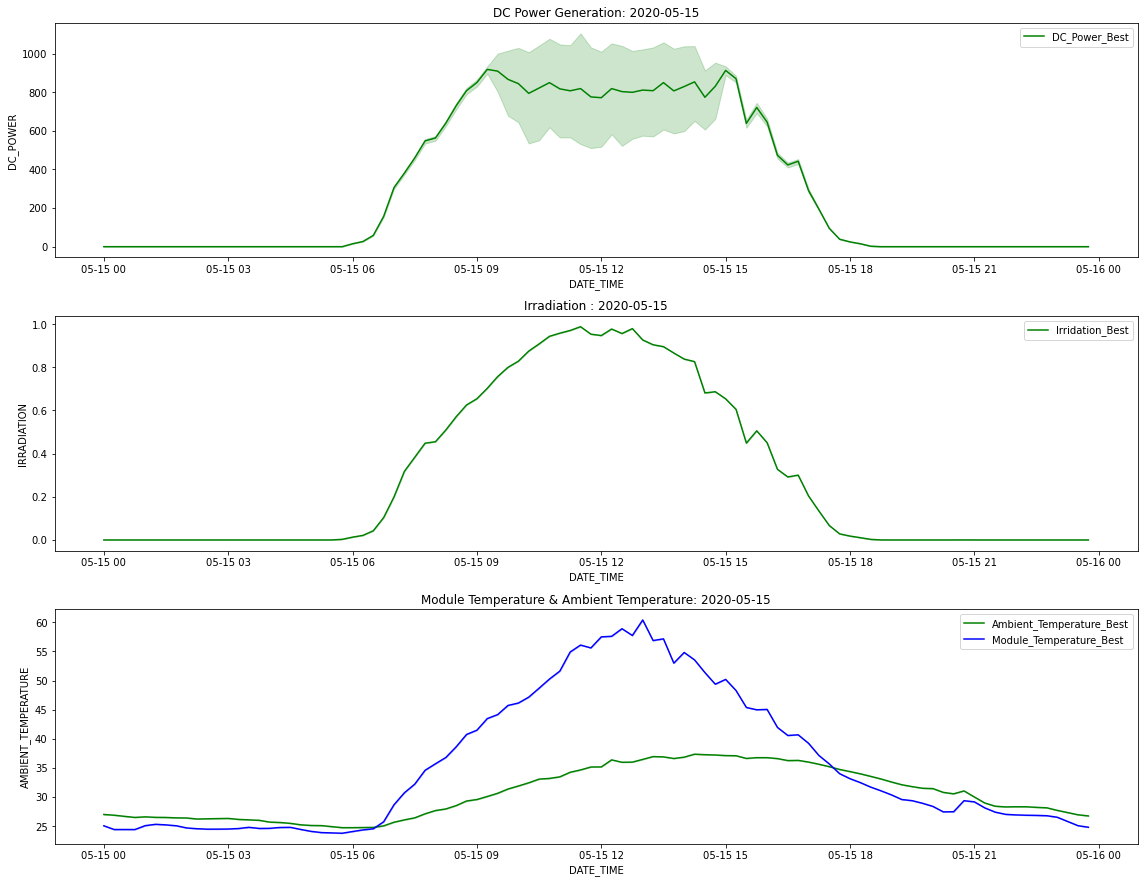

In [25]:
#Best and Worst Power generation comparision:
#Highest average DC_POWER is generated on "2020-05-15"
plt.figure(figsize=(16,16))

date=["2020-05-15"]

plt.subplot(411)
sns.lineplot(df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, df_solar[df_solar["DATE_STRING"].isin(date)].DC_POWER, label="DC_Power_Best",color='green');
plt.title("DC Power Generation: {}" .format(date[0]))

plt.subplot(412)
sns.lineplot(df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, df_solar[df_solar["DATE_STRING"].isin(date)].IRRADIATION, label="Irridation_Best",color='green');
plt.title("Irradiation : {}" .format(date[0]))

plt.subplot(413)
sns.lineplot(df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, df_solar[df_solar["DATE_STRING"].isin(date)].AMBIENT_TEMPERATURE, label="Ambient_Temperature_Best",color='green');
sns.lineplot(df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, df_solar[df_solar["DATE_STRING"].isin(date)].MODULE_TEMPERATURE, label="Module_Temperature_Best",color='blue');
plt.title("Module Temperature & Ambient Temperature: {}" .format(date[0]));

plt.tight_layout()
plt.show()

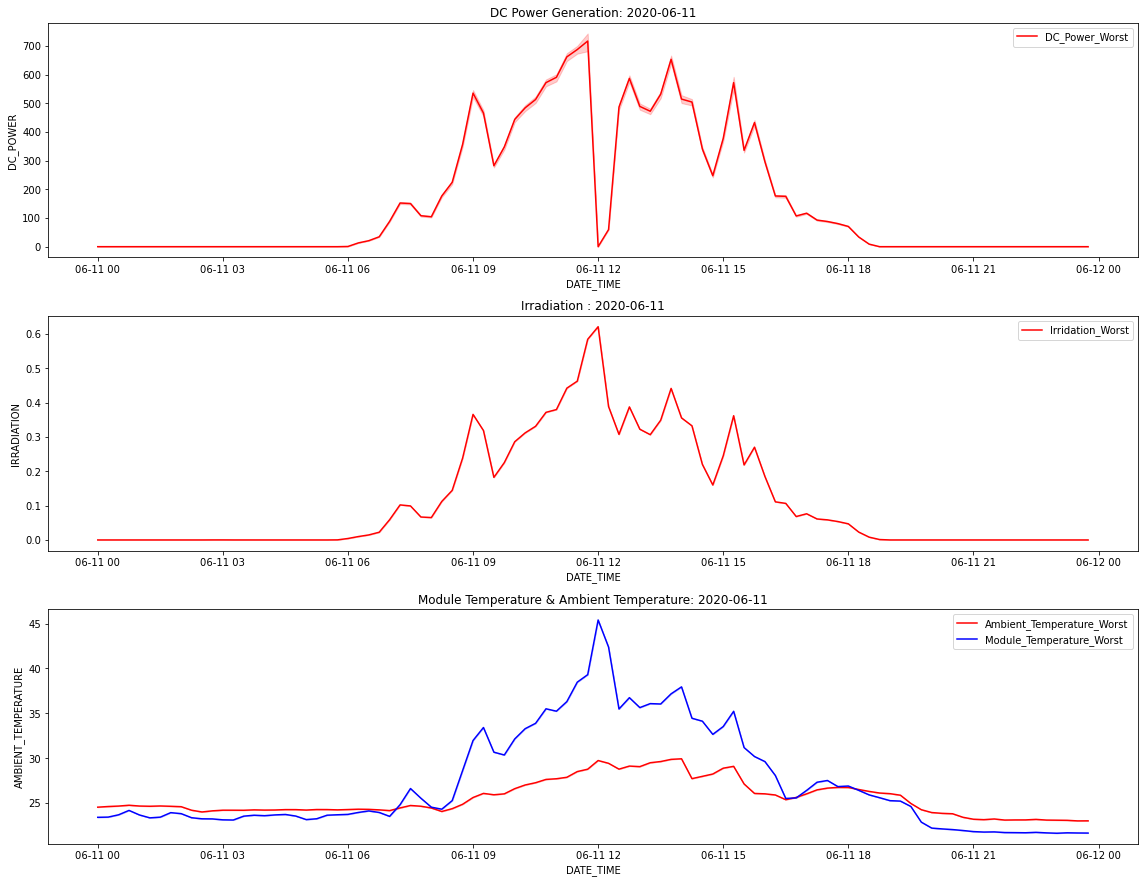

In [26]:
#Lowest average DC_POWER is generated on "2020-06-11"
date=["2020-06-11"]
plt.figure(figsize=(16,16))

plt.subplot(411)
sns.lineplot(df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, df_solar[df_solar["DATE_STRING"].isin(date)].DC_POWER, label="DC_Power_Worst",color='red');
plt.title("DC Power Generation: {}" .format(date[0]))

plt.subplot(412)
sns.lineplot(df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, df_solar[df_solar["DATE_STRING"].isin(date)].IRRADIATION, label="Irridation_Worst",color='red');
plt.title("Irradiation : {}" .format(date[0]))

plt.subplot(413)
sns.lineplot(df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, df_solar[df_solar["DATE_STRING"].isin(date)].AMBIENT_TEMPERATURE, label="Ambient_Temperature_Worst",color='red');
sns.lineplot(df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, df_solar[df_solar["DATE_STRING"].isin(date)].MODULE_TEMPERATURE, label="Module_Temperature_Worst",color='blue');
plt.title("Module Temperature & Ambient Temperature: {}" .format(date[0]));

plt.tight_layout()
plt.show()

In [27]:
#NOTE: There are very large fluctuations in both DC_POWER graph and IRRADIATION graph

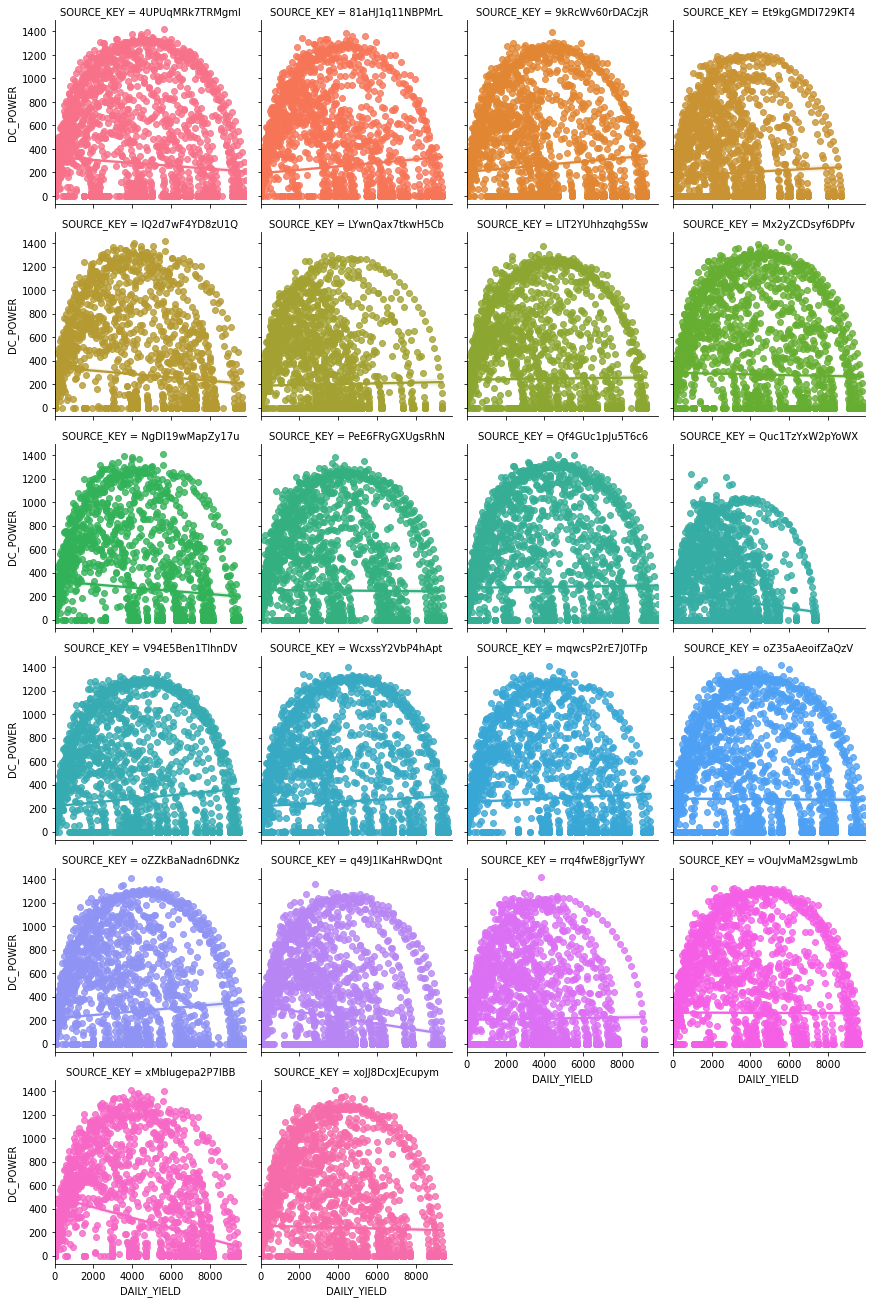

In [28]:
sns.lmplot(y="DC_POWER",x="DAILY_YIELD",hue="SOURCE_KEY",col="SOURCE_KEY",height=3,col_wrap=4,data=df_solar,fit_reg=True);

In [29]:
#Solar Power Plant Inverter Efficiency Calculation

In [30]:
solar_dc_power = df_solar[df_solar['DC_POWER'] > 0]['DC_POWER'].values
solar_ac_power = df_solar[df_solar['AC_POWER'] > 0]['AC_POWER'].values

In [31]:
solar_plant_eff = (np.max(solar_ac_power)/np.max(solar_dc_power ))*100
print(f"Power ratio AC/DC (Efficiency) of Solar Power Plant:  {solar_plant_eff:0.3f} %")

Power ratio AC/DC (Efficiency) of Solar Power Plant:  97.501 %


In [32]:
AC_list=[]
for i in df_solar['AC_POWER']:
    if i>0:
        AC_list.append(i)
AC_list
#AC_list.sort()
#AC_list.reverse()
len(AC_list)

32036

In [33]:
#Here we take all nonzero DC values and plot them on histogram
DC_list=[]
for i in df_solar['DC_POWER']:
    if i>0:
        DC_list.append(i)
DC_list
DC_list.sort()
DC_list.reverse()
len(DC_list)

32036

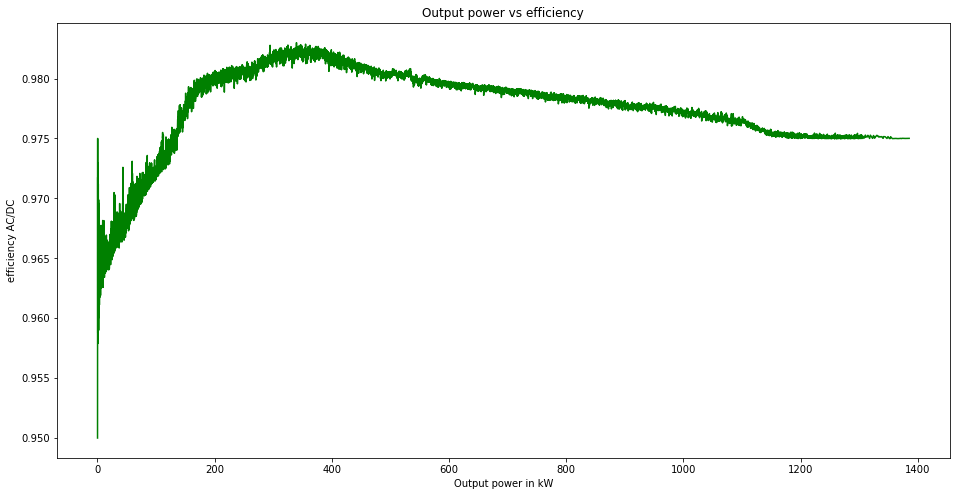

In [34]:
plt.figure(figsize=(16,8))
AC_list.sort()
DC_list.sort()
#print(DC_list)
#DC_list.sort
#res = [i / 10 for i in AC_list]
eff = [i/j for i,j in zip(AC_list,DC_list)]

plt.plot(AC_list,eff,color='green')
plt.xlabel('Output power in kW')
plt.ylabel('efficiency AC/DC')
plt.title('Output power vs efficiency');

In [35]:
#Solar Power Prediction
df2 = df_solar.copy()
X = df2[['DAILY_YIELD','TOTAL_YIELD','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION','DC_POWER']]
y = df2['AC_POWER']

In [36]:
X.head()

,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER
0,9425.000,2.429e+06,27.005,25.061,0.0,0.0
1,0.000,1.215e+09,27.005,25.061,0.0,0.0
2,3075.333,2.248e+09,27.005,25.061,0.0,0.0
3,269.933,1.704e+06,27.005,25.061,0.0,0.0
4,3177.000,1.994e+07,27.005,25.061,0.0,0.0


In [37]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: AC_POWER, dtype: float64

In [38]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=21)

In [39]:
#LINEAR REGRESSION
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
score_lr = 100*lr_clf.score(X_test,y_test)
print(f'LR Model score = {score_lr:4.4f}%')

LR Model score = 99.9994%


In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)
R2_Score_lr = round(r2_score(y_pred_lr,y_test) * 100, 2)

print("R2 Score : ",R2_Score_lr,"%")

R2 Score :  100.0 %


In [41]:
#RANDOM FOREST REGRESSOR
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred_rfr = lr.predict(X_test)
R2_Score_rfr = round(r2_score(y_pred_rfr,y_test) * 100, 2)

print("R2 Score : ",R2_Score_rfr,"%")

R2 Score :  100.0 %


In [42]:
#DECISION TREE REGRESSOR
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)

y_pred_dtr = lr.predict(X_test)
R2_Score_dtr = round(r2_score(y_pred_dtr,y_test) * 100, 2)

print("R2 Score : ",R2_Score_dtr,"%")

R2 Score :  100.0 %


In [43]:
#RESULT PREDICTION
prediction = rfr.predict(X_test)
print(prediction)

[   0.            0.          684.72413333 ...    0.         1007.17094286
    0.        ]


In [44]:
cross_checking = pd.DataFrame({'Actual' : y_test , 'Predicted' : prediction})
cross_checking.head()

,Actual,Predicted
40426,0.000,0.000
50974,0.000,0.000
53919,684.913,684.724
2384,0.000,0.000
22014,0.000,0.000


In [45]:
cross_checking['Error'] = cross_checking['Actual'] - cross_checking['Predicted']
cross_checking.head()

,Actual,Predicted,Error
40426,0.000,0.000,0.000
50974,0.000,0.000,0.000
53919,684.913,684.724,0.189
2384,0.000,0.000,0.000
22014,0.000,0.000,0.000


In [46]:
cross_checking_final  = cross_checking[cross_checking['Error'] <= 20]
cross_checking_final.sample(25).style.background_gradient(
        cmap='coolwarm').set_properties(**{
            'color': 'LigntGreen',
            'font-size': '15px'
        })

,Actual,Predicted,Error
47745,829.643,830.736,-1.093
45535,0.000,0.000,0.000
11054,0.000,0.000,0.000
25620,0.000,0.000,0.000
63663,0.000,0.000,0.000
46880,0.000,0.000,0.000
45098,100.280,100.297,-0.017
61267,0.000,0.000,0.000
31760,0.000,0.000,0.000
5840,6.667,6.672,-0.006


In [47]:
#TIMESERIES ATTEMPT

In [48]:
#step by step from the coding Elleh video
#Import the libraries

import os                                                     #view operating system file information
import pandas as pd                                           #for dataframe and data manipulations
import numpy as np                                            #Provides array objects for calculations
from numpy import cumsum                  
import matplotlib.pyplot as plt                               #For plots
from statsmodels.tsa.seasonal import seasonal_decompose       #import seasonal decompose
from scipy import signal                                      #For periodogram
from datetime import datetime                                #For datetime
from statsmodels.tsa.stattools import adfuller                #Import augmented dicky-fuller test function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #Plot ACF and PACF
from pandas.plotting import autocorrelation_plot              #Look for seasonalality in the data
import pmdarima as pm                                         #for auto-arima

from statsmodels.tsa.arima_model import ARIMA                 #To perform ARIMA analysis
from statsmodels.tsa.statespace.sarimax import SARIMAX        #to perform seasonal ARIMA analysis
import warnings                                               #to ignore warning
warnings.filterwarnings('ignore')
import joblib  

In [49]:
#shows matplotlib output inline in the jupyter notebook
%matplotlib inline

In [50]:
solar_clean = df_solar

In [51]:
solar_clean.head()

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE,TIME,DAY,MONTH,WEEK,HOURS,MINUTES,TOTAL MINUTES PASS,DATE_STRING,SOURCE_KEY_NUMBER
0,2020-05-15,4UPUqMRk7TRMgml,0.0,0.0,9425.000,2.429e+06,27.005,25.061,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15,0
1,2020-05-15,81aHJ1q11NBPMrL,0.0,0.0,0.000,1.215e+09,27.005,25.061,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15,1
2,2020-05-15,9kRcWv60rDACzjR,0.0,0.0,3075.333,2.248e+09,27.005,25.061,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15,2
3,2020-05-15,Et9kgGMDl729KT4,0.0,0.0,269.933,1.704e+06,27.005,25.061,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15,3
4,2020-05-15,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000,1.994e+07,27.005,25.061,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15,4


In [52]:
#Make time series stationary
#Test for stationarity

#identifying whether a time series, is stationary or non-stationary is very important.
result = adfuller(solar_clean['DAILY_YIELD'])

print('Test statistics', result[0])
print('p-value:',result[1])
print('Critical values:', result[4])

Test statistics -7.581624527382635
p-value: 2.67248288347045e-11
Critical values: {'1%': -3.430446688817956, '5%': -2.8615827347173726, '10%': -2.5667927462339284}


In [53]:
#HypO: Time series is non-stationary
#Hyp1: Time series is stationary

if result[1]<= 0.05:
    print('Reject null hypothesis, the time series is stationary')
else:
    print('Fail to reject the null hypothesis, the time series is non-stationary')

Reject null hypothesis, the time series is stationary


In [54]:
#Train test split

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=21)

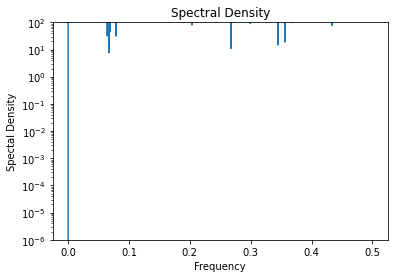

In [55]:
#Spectral Density 
f, Pxx_den = signal.periodogram(solar_clean['DAILY_YIELD'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectal Density')
plt.show()

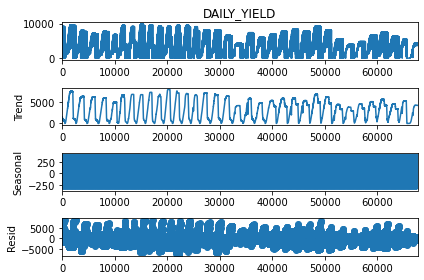

In [56]:
#Perform decomposition
########
decomp = seasonal_decompose(solar_clean.DAILY_YIELD, period=90)

#Plot decomp
decomp.plot()
plt.show()

<AxesSubplot:title={'center':'Seasonality'}>

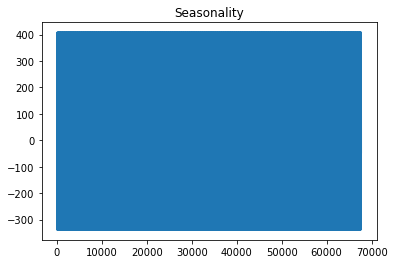

In [57]:
#Plot seasonality

plt.title('Seasonality')
decomp.seasonal.plot()

<AxesSubplot:title={'center':'Trend'}>

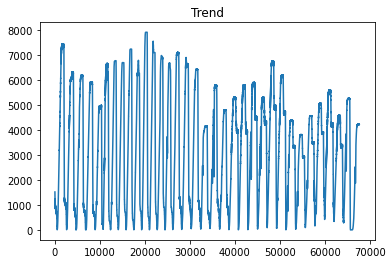

In [58]:
#View the trend
plt.title('Trend')
decomp.trend.plot()

<AxesSubplot:title={'center':'Residuals'}>

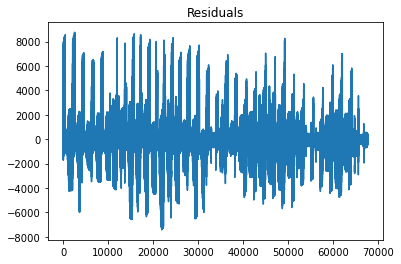

In [59]:
#Plot the residual
plt.title('Residuals')
decomp.resid.plot()

In [60]:
#autocorrelation_plot(solar_clean)
#plt.show()

In [69]:
#fix the shape of the 'DAILY_YIELD' BECAUSE IT'S 183, 183, 67699 FOR SOME REASON
#import numpy as np
#arr = np.array(['DAILY_YEILD'])

#solar_fix = arr.reshape(67699, 183)

In [70]:
#change array size to 1d
array_fix = solar_clean['DAILY_YIELD']

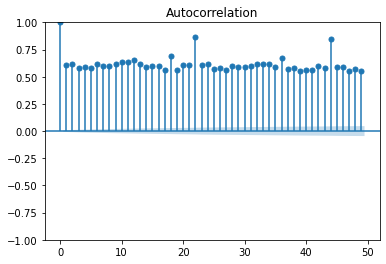

In [64]:
#Plot the ACF of md
plot_acf(array_fix)
plt.show()

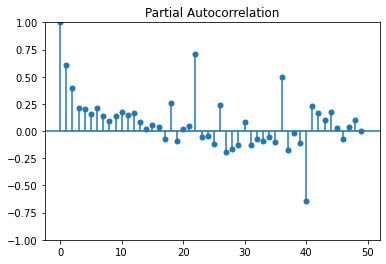

In [65]:
#partial autocorrelation
plot_pacf(array_fix)
plt.show()

In [66]:
#Pick best order by AIC. Smaller value for AIC is preferable_aic = np.inf

best_aic = np.inf
best_order = None
bestmdl = None
rng = range(3)
for p in rng: #loop over p values
    for q in rng: #loop over q values
        try:
            
            #create and fit ARIMA(p,q) model
            model = SARIMAX(array_fix, order=(p,1,q), trend='c')
            results = model.fit()
            tmp_aic = results.aic
            print(p, q, results.aic, results.bic)
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (p,q)
                best_mdl = tmp_mdl
        #Print order and results
        except:
            print(p,q, None, None)
            
print('nBest AIC: {:6.5f} | order: {}'.format(best_aic, best_order))

0 0 1255902.3219817802 1255920.5675760699
0 0 None None
0 1 1211058.3710889865 1211085.739480421
0 1 None None
0 2 1211776.6802524899 1211813.1714410689
1 0 1235370.3605117397 1235397.7289031742
1 1 1211037.072515147 1211073.563703726
1 1 None None
1 2 1207741.6141062847 1207787.2280920085
1 2 None None
2 0 1230067.3041993587 1230103.7953879377
2 1 1211037.142410174 1211082.7563958978
2 2 1207637.2873847869 1207692.0241676555
2 2 None None
nBest AIC: 1207637.28738 | order: (2, 2)


In [72]:
'''
import numpy as np

arr = np.array(['DAILY_YIELD'])

newarr = arr.reshape(67699)

print(newarr)

'''

"\nimport numpy as np\n\narr = np.array(['DAILY_YIELD'])\n\nnewarr = arr.reshape(67699)\n\nprint(newarr)\n\n"

In [ ]:
'''
#Auto ARIMA

#Find the best model using Auto-ARIMA. (Includes seasonality)
model = pm.auto_arima(array_fix,
                     seasonal=True, m=90,
                     d=1, D=1,
                     start_p=1, start_q=1,
                     max_p=2, max_q=2,
                     max_P=2, max_Q=2,
                     trace=True,
                     error_action='ignore',
                     suppress_warnings=True)

print(model.summary())   #Print model summary
'''

In [73]:
#Time series modeling

#Create the time series model

model = SARIMAX(array_fix, order=(1,1,0), seasonal_order=(1,1,0,90))
results = model.fit()
results.summary()

KeyboardInterrupt: 